# Data Analysis


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Problem:

Is there a relation between the use of safety equipments to the degree of fatality of a road accident?

To answer that, let's look at the 'users' table.

In [2]:
#Import the users table
users = pd.read_csv("./dataset/clean/users.csv")
users

,Num_Acc,place,catu,grav,sex,trip,secu_exist,secu_use,locp,actp,etatp,birth_year,num_veh
0,201600000001,1,1,1,2,0,1,1,0,0,0,1983,B02
1,201600000001,1,1,3,1,9,2,1,0,0,0,2001,A01
2,201600000002,1,1,3,1,5,1,1,0,0,0,1960,A01
3,201600000002,2,2,3,1,0,1,1,0,0,0,2000,A01
4,201600000002,3,2,3,2,0,1,1,0,0,0,1962,A01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873649,200500087953,1,1,1,1,0,1,3,0,0,0,1972,B01
1873650,200500087953,1,1,1,1,0,1,3,0,0,0,1965,C01
1873651,200500087953,1,1,4,1,5,2,3,0,0,0,1990,A01
1873652,200500087954,1,1,4,1,0,1,3,0,0,0,1951,A01


Concerning the problem, the relevant features are 'grav', which indicates degree of fatality, 'secu_exist' which indicates type of safety equipment available, and 'secu_use' which indicates the use of the safety equipment. Both variables are categorical.

The explanation of each values are as follows:


<h5 align="center">grav value and meaning table:</h5>

|Value | Meaning              |
|------|--------------------- |
| 1    | No injuries          |
| 2    | Killed               |
| 3    | Hospitalised         |
| 4    | Light injuries       |

<h5 align="center">secu_exist value and meaning table:</h5>

|Value | Meaning              |
|------|--------------------- |
| 1    | Belt                 |
| 2    | Helmet               |
| 3    | Child seat           |
| 4    | Reflective equipment |
| 9    | Other                |
    
<h5 align="center">secu_use value and meaning table:</h5>

|Value | Meaning            |
|------|------------------- |
| 1    | Used               |
| 2    | Not used           |
| 3    | Not determinable   |


Any other value other than those defined in the table will be dropped for data integrity.

In [3]:
#Drop non-used columns

used_cols = ["Num_Acc","grav","secu_exist","secu_use"]

users = users.loc[:,used_cols]

#Drop non-used values

def drop_values(df,used_value_dict):
    temp_df = df
    for column in used_value_dict.keys():
        temp_df = temp_df.loc[temp_df[column].isin(used_value_dict[column]),:]
    return temp_df

used_value_dict = {
    'grav':[1,2,3,4],
    'secu_exist':[1,2,3,4,9],
    'secu_use':[1,2,3]
}

users = drop_values(users,used_value_dict)

In addition, we might have to map the values to be more intuitive:

<h5 align="center">New grav value and meaning table:</h5>

| New Value | Old Value | Meaning        |
|-----------|-----------|----------------|
| 1         | 1         | No injuries    |
| 2         | 4         | Light injuries |
| 3         | 3         | Hospitalised   |
| 4         | 2         | Killed         |
    
<h5 align="center">New secu_exist value and meaning table:</h5>

| New Value            | Old Value | Meaning              |
|----------------------|-----------|----------------------|
| Belt                 | 1         | Belt                 |
| Helmet               | 2         | Helmet               |
| Child seat           | 3         | Child seat           |
| Reflective equipment | 4         | Reflective equipment |
| Other                | 9         | Other                |
    
<h5 align="center">New secu_use value and meaning table:</h5>

| New Value | Old Value | Meaning          |
|-----------|-----------|------------------|
| -1        | 2         | Not used         |
| 0         | 3         | Not determinable |
| 1         | 1         | Used             |



In [4]:
#Map new value
def map_new_value(df,value_map_dict):
    temp_df = df
    for column in value_map_dict.keys():
        temp_df[column] = temp_df[column].map(value_map_dict[column])
    return temp_df

value_map_dict = {
    'grav':{
        1:1,
        4:2,
        3:3,
        2:4
    },
    'secu_exist':{
        1:'Belt',
        2:'Helmet',
        3:'Child seat',
        4:'Reflective equipment',
        9:'Other'
    },
    'secu_use':{
        2:-1,
        3:0,
        1:1
    }
}

users = map_new_value(users,value_map_dict)

To gain an initial sense on how the three variables are related, we may look at the count of each combination of variables:

In [5]:
#Find the number of accidents of each combination of variables
users_grouped_by_secu = users.groupby(["secu_exist","secu_use"])
users_grouped_by_secu_count = users_grouped_by_secu.size().rename("grav").reset_index()

pivot_accident_count = pd.pivot(users_grouped_by_secu_count,index="secu_exist",columns="secu_use",values="grav")
pivot_accident_count["Total"] = pivot_accident_count.sum(axis=1)
pivot_accident_count = pivot_accident_count.append(pivot_accident_count.sum().rename("Total"))
pivot_accident_count

secu_use,-1,0,1,Total
secu_exist,,,,
Belt,32400,147718,1041800,1221918
Child seat,689,718,12727,14134
Helmet,19497,37141,341617,398255
Other,5865,99367,6612,111844
Reflective equipment,1395,1850,2227,5472
Total,59846,286794,1404983,1751623


It is seen that an overwhelming majority of road accidents are that of type secu_use=1 and secu_exist=1, which means that the majority of road accidents in France are the case where people use seatbelts.

Now this doesn't say anything about the likelihood of fatality for each category. In order to find that out, we may need to look at the mean of 'grav' (degree of fatality) for each category.

secu_use,-1,0,1,Mean
secu_exist,,,,
Belt,2.460957,1.546298,1.609269,1.872174
Child seat,2.316401,1.980501,1.796417,2.031106
Helmet,2.552393,2.173016,2.327905,2.351105
Other,2.161807,2.127608,1.813521,2.034312
Reflective equipment,2.554122,2.143243,2.186798,2.294721
Mean,2.409136,1.994133,1.946782,2.116684


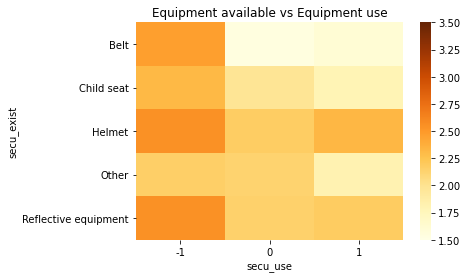

In [6]:
#Find the average degree of fatality of accidents of each combination of variables
users_grouped_by_secu = users.groupby(["secu_exist","secu_use"])
users_grouped_by_secu_grav_mean = users_grouped_by_secu.mean()["grav"].rename("grav").reset_index()

pivot_grav_mean = pd.pivot(users_grouped_by_secu_grav_mean,index="secu_exist",columns="secu_use",values="grav")
pivot_grav_mean["Mean"] = pivot_grav_mean.mean(axis=1)
pivot_grav_mean = pivot_grav_mean.append(pivot_grav_mean.mean().rename("Mean"))

fig = plt.figure()
ax = sns.heatmap(pivot_grav_mean.iloc[:-1,:-1],cmap="YlOrBr",vmin=1.5,vmax=3.5)
ax.set_title("Equipment available vs Equipment use")
fig.set_facecolor('white')
fig.set_alpha(1)
pivot_grav_mean

Now, this heatmap caters to our intuition. People not using safety equipments are on average more likely to have more dangerous outcomes in an accident.

Next step, for each combination of secu_exist and secu_use, we might analyze the probability of each degree of fatality.

First, we count the frequency of each combination of secu_exist, secu_use, and grav:

In [7]:
users_grouped_by_secu_grav_count = users_grouped_by_secu["grav"].value_counts().sort_index().rename("size").reset_index()
users_grouped_by_secu_grav_count.sort_values(["secu_use","secu_exist"]).head(15)

,secu_exist,secu_use,grav,size
0,Belt,-1,1,7623
1,Belt,-1,2,7952
2,Belt,-1,3,11092
3,Belt,-1,4,5733
12,Child seat,-1,1,133
13,Child seat,-1,2,259
14,Child seat,-1,3,243
15,Child seat,-1,4,54
24,Helmet,-1,1,1140
25,Helmet,-1,2,7865


Let's make a plot to see the proportion of fatality for each secu_exist and secu_use group.

In [8]:
def fatality_degree_proportion_plot(secu_grav_group,ax):
    
    df = secu_grav_group
    
    #Sort columns for better intuition
    df = df.loc[:,["secu_exist","grav","secu_use","size"]]
    #Map grav values
    grav_value_map = {
        1:"No injuries",
        2:"Light injuries",
        3:"Hospitalised",
        4:"Killed"
    }
    df["grav"] = df["grav"].map(grav_value_map)
    #Map secu_use values
    secu_use_value_map = {
        -1:"Not used",
        0:"Indeterminable",
        1:"Used"
    }
    df["secu_use"] = df["secu_use"].map(secu_use_value_map)
    df = df.sort_values("grav")    

    #Calculate percentage of each group
    for grav_type in list(df.loc[:,"grav"].values):
        df.loc[df.grav == grav_type,"percentage"] = np.divide(df.loc[df.grav == grav_type,"size"],df.loc[df.grav == grav_type,"size"].sum())*100

    #Create arrays to plot each bar
    grav_type = list(df.loc[:,"grav"].value_counts().index) #grav array shape (1,4:types of grav)
    secu_use = list(df.secu_use.value_counts().index) #secu_use array shape (1,3:types of secu_use)
    percentage = np.array(df["percentage"]).reshape(-1,len(secu_use)).T #percentage array shape (3:percentages for each secu_use,4:each grav)
    left = np.cumsum(np.append(np.zeros((1,len(grav_type))),percentage,axis=0),axis=0) #for left parameter in ax.barh()
    
    #Sort array columns to be: ["No injuries","Light injuries","Hospitalised","Killed"] (for better graph)
    sort_grav_dict = dict(zip(grav_type,range(len(grav_type))))
    column_sorted = [sort_grav_dict["No injuries"],sort_grav_dict["Light injuries"],sort_grav_dict["Hospitalised"],sort_grav_dict["Killed"]]
    
    #Sort columns
    grav_type = np.array(grav_type)[column_sorted]
    percentage = np.array(percentage)[:,column_sorted]
    left = np.array(left)[:,column_sorted]
    
    #Plot
    for i in range(len(secu_use)):
        ax.barh(grav_type,percentage[i,:],left=left[i,:],label=secu_use[i])
        
    #Complete the graph
    title = df.secu_exist.value_counts().index[0]
    ax.legend()
    ax.set_title(title,fontsize=16)
    ax.set_ylabel("Type of safety equipment")
    ax.set_xlabel("Percentage (%)")
    ax.set_xticks(range(0,101,10))
    return ax


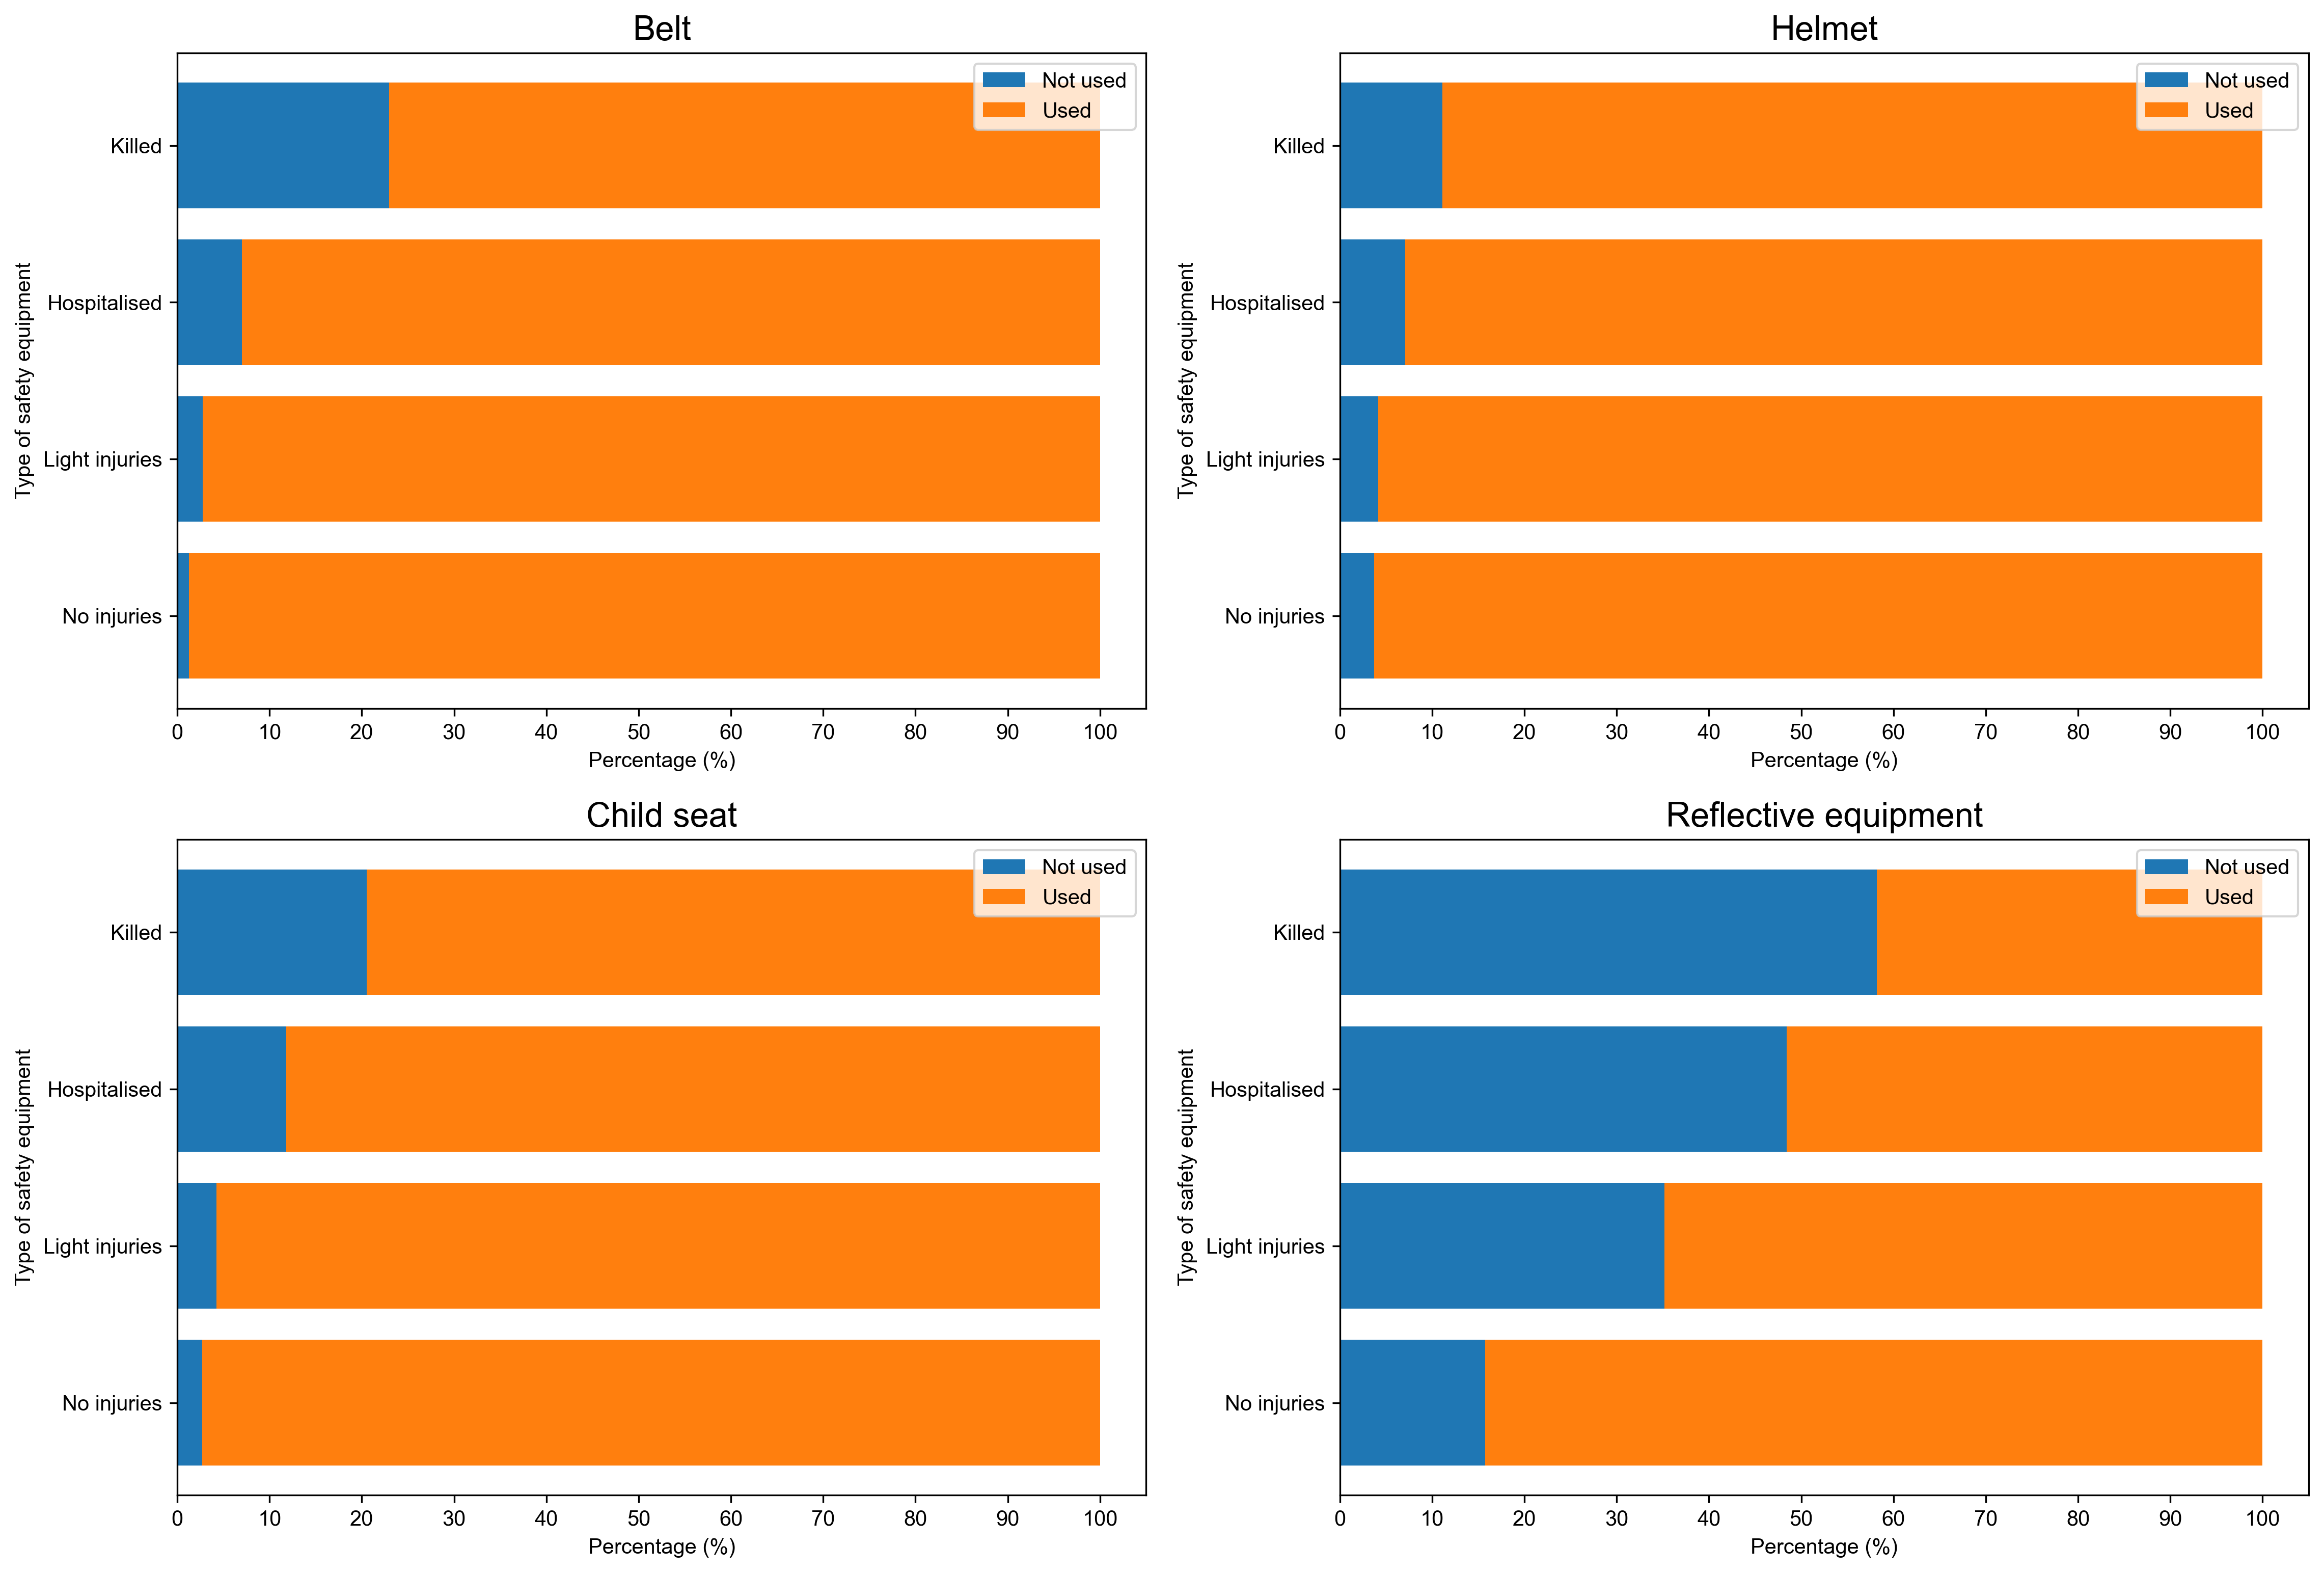

In [9]:
fig,ax = plt.subplots(2,2)


for i,secu_exist in enumerate(["Belt","Helmet","Child seat","Reflective equipment"]):
    row = i//2
    column = i%2
    fatality_degree_proportion_plot(users_grouped_by_secu_grav_count
                                    [(users_grouped_by_secu_grav_count.secu_exist == secu_exist)
                                     & (users_grouped_by_secu_grav_count.secu_use != 0)
                                    ],ax[row][column])

sns.set()
fig.set_size_inches((18,12.5))
fig.set_facecolor('white')
fig.set_alpha(1)
fig.set_dpi(300)

Now it's clear that for each type of safety equipments, the degree of fatality of the accident is higher if people do not use the safety equipments.

Although from the looks of it, different types of safety equipments may have different proportions or percentages, but the trend that not using safety equipments will cause a more fatal accident is clear.

### Conclusion:

People not using the available safety equipments will make an accident more likely to have a fatal outcome. (Duh!)